# 1. Environment Setup

## 1.1 Install Dependencies, Clone NeMo & Install Editable Version

In [2]:
import time
## Update & Upgrade
# !apt-get update -y
# !apt-get upgrade -y

## Install dependencies
# !apt-get install -y build-essential python3-dev sox libsndfile1 ffmpeg
# !pip install wget text-unidecode matplotlib>=3.3.2 -y
# !pip install mamba-ssm
!pip install gdown noisereduce wandb
!apt install tree -y
!pip install google-api-python-client google-auth google-auth-oauthlib google-auth-httplib2 watchdog

## Clone NeMo repo
NEMO_DIR = 'nemo'
!git clone https://github.com/NVIDIA/NeMo.git $NEMO_DIR
!git clone https://github.com/nipponjo/tts-arabic-pytorch.git

start = time.time()
## Install NeMo
BRANCH = 'main'
!python -m pip install "git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]"
# !pip install "git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]" -v

end = time.time()
print(f"Installation took {(end - start):.2f} seconds.")

# exit() # Optional for restarting the kernel

In [3]:
import re
import gdown
import json
import os
import subprocess
import sys
import numpy as np
import librosa
import soundfile as sf
import noisereduce as nr
from tqdm import tqdm
from googleapiclient.discovery import build
from google.oauth2 import service_account
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from nemo.collections.tts.models import HifiGanModel, FastPitchModel, MixerTTSModel
print('NeMo got loaded!')

NeMo got loaded!


# 2. Data Preparation

In [ ]:
# NAWAR
# SERVICE_ACCOUNT_FILE = '/kaggle/input/driveapi/arabicttsnawarapi-d3869f3ca448.json'
# PARENT_FOLDER_ID = "1ewhmkjhfTVCh7GLdXtVFQhgR60JYsL92"
# train_sub_data = "/kaggle/working/train_sup_data"
# PITCH_MEAN=129.74388122558594
# PITCH_STD=19.90825653076172
# PITCH_MIN=65.4063949584961
# PITCH_MAX=1719.801513671875
# # pitch_fmin=65.4063949584961 
# # pitch_fmax=2057.0478515625 
# # pitch_mean=132.2518768310547 
# # pitch_std=24.731098175048828 

# MBZUAI
SERVICE_ACCOUNT_FILE = '/kaggle/input/driveapi/arabicttsnawarapi-mbzuai.json'
PARENT_FOLDER_ID = "1BXXPLxSV_sj6V4wuc2vnPvzTI5yjLbJW"
train_sub_data = "/kaggle/working/mbzuai_train_sup_data"
PITCH_MIN=65.4063949584961 
PITCH_MAX=1303.3658447265625 
PITCH_MEAN=112.00650787353516 
PITCH_STD=22.997333526611328
# PITCH_MEAN=117.74093627929688 
# PITCH_STD=22.71845245361328
# PITCH_MIN=65.4063949584961
# PITCH_MAX=1930.4119873046875

## Nawar_Data

In [ ]:
import os
import json
import numpy as np
import scipy.io.wavfile as wavfile
from datasets import load_dataset

# Load the arabic_speech_corpus dataset
nawar_dataset = load_dataset("halabi2016/arabic_speech_corpus")

In [ ]:
nawar_dataset

In [ ]:
import sys
sys.path.append('tts-arabic-pytorch/text/')  # Add the script's directory to Python path
from phonetise_buckwalter import (
    arabic_to_buckwalter,
    buckwalter_to_arabic,
    process_utterance
)

def custom_arabic_to_phones(text, return_phonemes=True):
    # Step 1: Convert remaining Arabic to Buckwalter
    bw_text = arabic_to_buckwalter(text)

    # Step 2: Cleanup (optional)
    # bw_text = bw_text.replace("~", "")  # Remove tashkeel marks if unwanted

    if return_phonemes:
        # Step 3: Convert to phonemes if requested
        return bw_text, process_utterance(bw_text).replace("+ ", "")
    return bw_text

# Example usage:

# "ARA NORM  0002.wav" "w a r a jj a H a tt A q r ii0 r u0 ll a * ii0 < a E a dd a h u0 m a E h a d u0 < a b H aa ^ i0 h A D A b a t i0 tt i0 b i0 t i0 f ii0 l < a k aa d ii0 m ii0 y a t i0 SS II0 n ii0 y a t i0 l i0 l E u0 l uu0 m i0 sil < a n t a s t a m i0 rr a d a r a j aa t u0 l H a r aa r a t i0 w a m u0 s t a w a y aa t u0 rr U0 T UU0 b a t i0 f ii0 l < i0 r t i0 f aa E i0 T A w aa l a h aa * aa l q A r n"
# text = "وَرَجَّحَ التَّقْرِيرُ الَّذِي أَعَدَّهُ مَعْهَدُ أَبْحَاثِ هَضَبَةِ التِّبِتِ فِي الْأَكَادِيمِيَّةِ الصِّينِيَّةِ لِلْعُلُومِ - أَنْ تَسْتَمِرَّ دَرَجَاتُ الْحَرَارَةِ وَمُسْتَوَيَاتُ الرُّطُوبَةِ فِي الْإِرْتِفَاعِ طَوَالَ هَذَا الْقَرْنْ"
# text = ":وَقِيلَ لِمُعَاوِيَةَ أَيُّمَا أَحَبُّ إلَيْك؟ .قَالَ: صَدِيقٌ يُحَبِّبُنِي إلَى النَّاسِ"

# Get Buckwalter (original functionality)
# text_buckwalter , text_phonemes = custom_arabic_to_phones(text)
# print("\nBuckwalter text sample:")
# print(text_buckwalter)
# print("\nPhonemes sample:")
# print(text_phonemes)
process_utterance(nawar_dataset["train"][1]["orthographic"]).replace("+ ", "")

### 2.1.1 Dataset Download (from Drive)

In [ ]:
# Replace 'FILE_ID' with your actual file ID from Google Drive
file_id = '1oWoqhTDgwuYyUJEiTTFzQ7hiIDiaul6P' 
gdown.download(f"https://drive.google.com/uc?id={file_id}", 'nawar_audio_data.zip', quiet=False)

In [ ]:
!unzip -q nawar_audio_data.zip -d nawar_dataset

In [ ]:
!mv /kaggle/working/nawar_dataset/content/audio_data/audio_preprocessed_train/* /kaggle/working/nawar_dataset
!mv /kaggle/working/nawar_dataset/content/audio_data/audio_preprocessed_val/* /kaggle/working/nawar_dataset
!rm -rf nawar_dataset/content

In [ ]:
!find /kaggle/working/nawar_dataset -type f -name "*.flac" | wc -l


In [ ]:
!wget https://raw.githubusercontent.com/nawarhalabi/Arabic-Phonetiser/master/utterance-pronunciations.txt


## 2.4 Create Manifest Files

In [ ]:
import json

input_txt_path = "/kaggle/working/utterance-pronunciations.txt"
output_jsonl_path = "utterance-pronunciations.json"

with open(input_txt_path, "r", encoding="utf-8") as fin, open(output_jsonl_path, "w", encoding="utf-8") as fout:
    for line in fin:
        line = line.strip()
        if not line:
            continue
        # Safely split using quote pattern
        if line.startswith('"') and line.count('"') >= 4:
            parts = line.split('" "')
            if len(parts) == 2:
                filename = parts[0].strip('"')
                transcription = parts[1].strip('"')
                entry = {
                    "audio_filepath": filename,
                    "text": transcription
                }
                fout.write(json.dumps(entry, ensure_ascii=False) + "\n")


In [ ]:
import json
import random

# Paths
input_jsonl_path = "utterance-pronunciations.json"
train_output_path = "train.json"
val_output_path = "val.json"

# Load all lines
with open(input_jsonl_path, "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f if line.strip()]

# Shuffle the data for random splitting
random.seed(42)
random.shuffle(data)

# Split ratio (e.g., 80% train, 20% val)
split_ratio = 0.8
split_index = int(len(data) * split_ratio)

train_data = data[:split_index]
val_data = data[split_index:]

# Write train.json
with open(train_output_path, "w", encoding="utf-8") as f:
    for item in train_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

# Write val.json
with open(val_output_path, "w", encoding="utf-8") as f:
    for item in val_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

print(f"✅ Done! Train: {len(train_data)} samples | Val: {len(val_data)} samples")

In [ ]:
import json
import soundfile as sf  # Make sure to install via: pip install soundfile

def modify_json_file(file_path, output_path, old_path, new_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                entry = json.loads(line.strip())
                data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")

    for entry in data:
        # Build new audio path
        new_audio_path = new_path + entry['audio_filepath'].replace(".wav", ".flac")
        # new_audio_path = new_path + entry['audio_filepath']
        entry['audio_filepath'] = new_audio_path

        # Compute duration using soundfile
        
        try:
            audio_info = sf.info(new_audio_path)
            entry['duration'] = round(audio_info.frames / audio_info.samplerate, 3)  # in seconds, rounded to 3 decimals
        except RuntimeError as e:
            print(f"Error reading audio file {new_audio_path}: {e}")
            entry['duration'] = None  # or you can skip this entry

    with open(output_path, 'w', encoding='utf-8') as f:
        for item in data:
            json.dump(item, f, ensure_ascii=False)
            f.write('\n')

    print(f"✅ File paths and durations updated successfully for {output_path}!")


In [ ]:
# Define paths for training and validation datasets
train_file_path   = '/kaggle/working/train.json'   # Path for training dataset
val_file_path     = '/kaggle/working/val.json'     # Path for validation dataset
train_output_path = '/kaggle/working/train_data.json'                           # Output path for modified training dataset
val_output_path   = '/kaggle/working/val_data.json'                           # Output path for modified validation dataset
old_audio_path    = '/content/audio_data/audio_preprocessed_'                   # Current path in the JSON 
new_audio_path_train  = '/kaggle/working/nawar_dataset/'    # New path to replace with

# Modify JSON for training and validation
modify_json_file(train_file_path, train_output_path, old_audio_path + "train", new_audio_path_train)
modify_json_file(val_file_path, val_output_path, old_audio_path + "val", new_audio_path_train)

In [ ]:
data_prev = []
with open(train_file_path, 'r', encoding='utf-8') as f:
    for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data_prev.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                
data_prev[2]

In [ ]:
data = []
with open(train_output_path, 'r', encoding='utf-8') as f:
    for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                
data[2]

In [ ]:
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

def remove_silence_energy_threshold(
    audio_path,
    output_path,
    frame_length=2048,
    hop_length=512,
    energy_threshold_ratio=0.1
):
    y, sr = librosa.load(audio_path, sr=None)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    threshold = energy_threshold_ratio * np.max(rms)
    non_silent_frames = np.where(rms > threshold)[0]

    if len(non_silent_frames) == 0:
        print(f"No non-silent frames found for {audio_path}")
        return

    intervals = librosa.frames_to_samples(non_silent_frames, hop_length=hop_length)
    cleaned_audio = []

    for i in intervals:
        start = i
        end = min(i + hop_length, len(y))
        cleaned_audio.extend(y[start:end])

    cleaned_audio = np.array(cleaned_audio)
    sf.write(output_path, cleaned_audio, sr, format='FLAC')

def process_folder(input_folder, output_folder, energy_threshold_ratio=0.1):
    os.makedirs(output_folder, exist_ok=True)
    flac_files = [f for f in os.listdir(input_folder) if f.endswith('.flac')]

    for flac_file in tqdm(flac_files, desc="Processing audio files"):
        input_path = os.path.join(input_folder, flac_file)
        output_path = os.path.join(output_folder, flac_file)
        remove_silence_energy_threshold(
            audio_path=input_path,
            output_path=output_path,
            energy_threshold_ratio=energy_threshold_ratio
        )

# Example usage
# process_folder(
#     input_folder='/kaggle/working/nawar_dataset',
#     output_folder='/kaggle/working/nawar_cleaned_dataset',
#     energy_threshold_ratio=0.1
# )


In [ ]:
# Define paths for training and validation datasets
train_file_path   = '/kaggle/working/train.json'   # Path for training dataset
val_file_path     = '/kaggle/working/val.json'     # Path for validation dataset
train_output_path = '/kaggle/working/train_data.json'                           # Output path for modified training dataset
val_output_path   = '/kaggle/working/val_data.json'                           # Output path for modified validation dataset
old_audio_path    = '/content/audio_data/audio_preprocessed_'                   # Current path in the JSON 
new_audio_path_train  = '/kaggle/working/nawar_cleaned_dataset/'    # New path to replace with

# Modify JSON for training and validation
modify_json_file(train_file_path, train_output_path, old_audio_path + "train", new_audio_path_train)
modify_json_file(val_file_path, val_output_path, old_audio_path + "val", new_audio_path_train)

In [ ]:
data = []
with open(train_output_path, 'r', encoding='utf-8') as f:
    for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                
data[2]

## MBZUAI Data

In [ ]:
!gdown 1yUXGteld79-gDq2MCnk6gWcPHwyYzq1z
!gdown 1rG2CN68fZY94usUBTV7z35Ir1Biw8EYd

In [ ]:
!unzip /kaggle/working/MBZUAI_ClArTTS_cleaned.zip
!unzip -j /kaggle/working/MBZUAI_ClArTTS_data_preprocessed.zip content/MBZUAI_ClArTTS_data_preprocessed/train_data_preprocessed.json content/MBZUAI_ClArTTS_data_preprocessed/val_data_preprocessed.json
# !unzip /kaggle/working/MBZUAI_ClArTTS_data_preprocessed.zip
# !mv /kaggle/working/content/MBZUAI_ClArTTS_data_preprocessed /kaggle/working/MBZUAI_ClArTTS_data_preprocessed
!mv /kaggle/working/kaggle/working/MBZUAI_ClArTTS_cleaned /kaggle/working/MBZUAI_ClArTTS_cleaned

In [ ]:
data_prev = []
with open('/kaggle/working/train_data_preprocessed.json', 'r', encoding='utf-8') as f:
    for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data_prev.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                
len(data_prev), data_prev[50]

In [ ]:
# Example usage
# process_folder(
#     input_folder='/kaggle/working/MBZUAI_ClArTTS_data_preprocessed/audio_preprocessed',
#     output_folder='/kaggle/working/MBZUAI_ClArTTS_cleaned',
#     energy_threshold_ratio=0.03
# )

In [ ]:
# !zip -r /kaggle/working/MBZUAI_ClArTTS_cleaned.zip /kaggle/working/MBZUAI_ClArTTS_cleaned
# upload_file("/kaggle/working/MBZUAI_ClArTTS_cleaned.zip")

In [ ]:
def modify_json_file(file_path, output_path, old_path, new_path):
    # Load the JSON data from the file
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")

    # Modify the file paths
    for entry in data:
        # Update the file path to the new directory
        entry.pop('ar_text', None)  # safely remove without KeyError if not present
        entry['audio_filepath'] = entry['audio_filepath'].replace(old_path, new_path)
        # entry['text']           = "sil " + entry['text'] + " sil"
        entry['text'] =  entry['text'].replace(".", "")

        try:
            audio_info = sf.info(entry['audio_filepath'])
            entry['duration'] = round(audio_info.frames / audio_info.samplerate, 3)  # in seconds, rounded to 3 decimals
        except RuntimeError as e:
            print(f"Error reading audio file {entry['audio_filepath']}: {e}")
            entry['duration'] = None  # or you can skip this entry
    # Save the modified data back to a JSON file
    with open(output_path, 'w', encoding='utf-8') as f:
        for item in data:
            json.dump(item, f, ensure_ascii=False)  # Use ensure_ascii=False to maintain Arabic characters
            f.write('\n')  # Write each JSON object on a new line

    print(f"File paths updated successfully for {output_path}!")

# Define paths for training and validation datasets
train_file_path   = '/kaggle/working//train_data_preprocessed.json'   # Path for training dataset
val_file_path     = '/kaggle/working//val_data_preprocessed.json'     # Path for validation dataset
train_output_path = '/kaggle/working/train_data_preprocessed.json'                         # Output path for modified training dataset
val_output_path   = '/kaggle/working/val_data_preprocessed.json'                           # Output path for modified validation dataset
old_audio_path    = '/content/MBZUAI_ClArTTS_data_preprocessed/audio_preprocessed'                                            # Current path in the JSON 
new_audio_path    = '/kaggle/working/MBZUAI_ClArTTS_cleaned'                                # New path to replace with

# Modify JSON for training and validation
modify_json_file(train_file_path, train_output_path, old_audio_path, new_audio_path)
modify_json_file(val_file_path, val_output_path, old_audio_path, new_audio_path)


In [ ]:
data = []
with open(train_output_path, 'r', encoding='utf-8') as f:
    for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                
data[50]

# Testing downloading files

### Google drive API service account

In [ ]:
# Authentication and upload to drive
SCOPES = ['https://www.googleapis.com/auth/drive']
# SERVICE_ACCOUNT_FILE = '/kaggle/input/driveapi/arabicttsnawarapi-d3869f3ca448.json'
# PARENT_FOLDER_ID = "1ewhmkjhfTVCh7GLdXtVFQhgR60JYsL92"

def authenticate():
    creds = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
    return creds
    
def list_files():
    creds = authenticate()
    service = build('drive', 'v3', credentials=creds)
    results = service.files().list(pageSize=100, fields="files(id, name)").execute()
    files = results.get('files', [])
    if not files:
        print("No files found.")
    else:
        print("Files:")
        for file in files:
            print(f"{file['name']} (ID: {file['id']})")

def delete_file(file_id):
    creds = authenticate()
    service = build('drive', 'v3', credentials=creds)
    try:
        service.files().delete(fileId=file_id).execute()
        print(f"Deleted file with ID: {file_id}")
    except Exception as e:
        print(f"An error occurred: {e}")
        
def upload_file(file_path):
    creds = authenticate()
    service = build('drive', 'v3', credentials=creds)
    file_name = os.path.basename(file_path)
    file_metadata = {
        'name': file_name,
        'parents': [PARENT_FOLDER_ID]
    }
    
    try:
        # Perform the upload
        uploaded_file = service.files().create(
            body=file_metadata,
            media_body=file_path
        ).execute()
        print(f"File '{file_name}' uploaded successfully with ID: {uploaded_file.get('id')}")
        return True  # Upload success
    except Exception as e:
        print(f"Failed to upload file '{file_name}': {e}")
        return False  # Upload failed


# Tokenizers

In [ ]:
# # Old tokinizer (has all possible phones with and without stress!)

# file_id = '1ujELwQEpFWdwQpqYZf1Ybor5o31vw42t' 
# gdown.download(f"https://drive.google.com/uc?id={file_id}", 'arabic_phoneme_tokenizer.py', quiet=False)

In [ ]:
def extract_phoneme_manifeast(filepath):
    phoneme_set = set()
    data=[]
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
    
    # Modify the file paths
    for entry in data:
        text = entry["text"]
        phonemes = text.split()  # Split by spaces
        phoneme_set.update(phonemes)
            
    # Convert set to sorted list
    return sorted(phoneme_set)

# Display
list1= extract_phoneme_manifeast(train_output_path)
list2= extract_phoneme_manifeast(val_output_path)
print(f"len list1:{len(list1)} \n{list1}")
print(f"\nlen list1:{len(list2)} \n{list2}")
unique_phonemes = sorted(set(list1) | set(list2))
print(f"len unique_phonemes:{len(unique_phonemes)} \n{unique_phonemes}")
list1==list2

In [4]:
%%writefile arabic_phoneme_tokenizer.py
import sys
sys.path.append('tts-arabic-pytorch')  # Add the script's directory to Python path
import nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers as tts_tokenizers
import text as txt
class ArabicPhonemeTokenizer(tts_tokenizers.BaseTokenizer):

    def __init__(self):
        self.phonemes = txt.symbols
        # Create phoneme dictionary
        self.phoneme_dict = txt.phon_to_id_
        self.vocab = self.phoneme_dict
        self.itos = list(self.vocab.keys())  # Index-to-string mapping
        self.stoi = self.vocab  # String-to-index mapping
        self.pad = txt.phon_to_id_["_pad_"]
        super().__init__(tokens=self.phoneme_dict)

    def encode(self, text):
        # Convert a phoneme sequence into a list of indices
        tokens = txt.phonemes_to_tokens(text, append_space=False)
        return txt.tokens_to_ids(tokens)

    def decode(self, tokens):
        # Convert a list of indices back into a phoneme sequence
        return ' '.join(txt.ids_to_tokens(tokens))

Writing arabic_phoneme_tokenizer.py


In [5]:
import sys
sys.path.append('/kaggle/working')  # Append the directory, not the file
import arabic_phoneme_tokenizer

obj1 = arabic_phoneme_tokenizer.ArabicPhonemeTokenizer()
# obj1 = ArabicPhonemeTokenizer()

phonemes = "r U0 S b a r a sil w a t a r U0 SS A r a sil w a t u0 r U0 S A r u1 n sil w a s a rr u1 n sil t A S A rr u0 r u0"
tokens_list = obj1.encode(phonemes)
print(tokens_list)
print(obj1.pad)
print(obj1.decode(tokens_list).strip())
obj1.decode(tokens_list).strip() , arabic_phoneme_tokenizer.txt.simplify_phonemes(phonemes), phonemes

[14, 35, 18, 6, 34, 14, 34, 31, 34, 7, 34, 14, 35, 18, 3, 34, 14, 34, 31, 34, 7, 35, 14, 35, 18, 34, 14, 35, 29, 31, 34, 16, 34, 14, 3, 35, 29, 7, 34, 18, 34, 14, 3, 35, 14, 35, 1]
40
r u S b a r a w a t a r u S _dbl_ a r a w a t u r u S a r u n w a s a r _dbl_ u n t a S a r _dbl_ u r u _eos_


('r u S b a r a w a t a r u S _dbl_ a r a w a t u r u S a r u n w a s a r _dbl_ u n t a S a r _dbl_ u r u _eos_',
 'r u S b a r a sil w a t a r u SS a r a sil w a t u r u S a r u n sil w a s a rr u n sil t a S a rr u r u',
 'r U0 S b a r a sil w a t a r U0 SS A r a sil w a t u0 r U0 S A r u1 n sil w a s a rr u1 n sil t A S A rr u0 r u0')

# Extracting Supplementary Data
## Extracting sub_data for training

/content/nemo/scripts/dataset_processing/tts/thorsten_neutral/ds_conf/ds_for_fastpitch_align.yaml

/content/nemo/scripts/dataset_processing/tts/extract_sup_data.py

### Editing the extract_sup_data.py

In [ ]:
file_path = "/kaggle/working/nemo/scripts/dataset_processing/tts/extract_sup_data.py"

# Read the file contents
with open(file_path, "r") as file:
    lines = file.readlines()

# Insert the new lines at the top (or after the first import block if needed)
new_lines = ["import sys\n", "sys.path.append('/kaggle/working/')\n"]

# Add the new lines at the top of the file
lines = new_lines + lines

# Write the updated content back to the file
with open(file_path, "w") as file:
    file.writelines(lines)

print(f"Added sys.path modification to {file_path}")


## The normal way of extract_sup_data.py

train sub data:
100% 7590/7590 [1:31:56<00:00,  1.38it/s]

PITCH_MEAN=132.2518768310547, PITCH_STD=24.731098175048828
PITCH_MIN=65.4063949584961, PITCH_MAX=2057.0478515625

In [ ]:
!HYDRA_FULL_ERROR=1 CUDA_VISIBLE_DEVICES=0 python /kaggle/working/nemo/scripts/dataset_processing/tts/extract_sup_data.py \
    --config-name="ds_for_fastpitch_align.yaml" \
    --config-path="/kaggle/working/nemo/scripts/dataset_processing/tts/thorsten_neutral/ds_conf" \
    manifest_filepath=/kaggle/working/train_data_preprocessed.json \
    sup_data_path=$train_sub_data \
    ++dataloader_params.num_workers=8 \
    ~dataset.text_normalizer \
    ~dataset.text_normalizer_call_kwargs \
    ++dataset.text_tokenizer._target_=arabic_phoneme_tokenizer.ArabicPhonemeTokenizer \
    ~dataset.text_tokenizer.punct \
    ~dataset.text_tokenizer.apostrophe \
    ~dataset.text_tokenizer.pad_with_space \

In [ ]:
# gdrive ID: https://drive.google.com/file/d/13co79a8rUtycxTzG6k5VEYKJji1epgW8/view?usp=sharing
# pitch stats: 
    # PITCH_MEAN=117.74093627929688, PITCH_STD=22.71845245361328
    # PITCH_MIN=65.4063949584961, PITCH_MAX=1930.4119873046875

!gdown 13co79a8rUtycxTzG6k5VEYKJji1epgW8
!unzip mbzuai_train_sup_data_cleaned.zip 
!mv /kaggle/working/kaggle/working/mbzuai_train_sup_data /kaggle/working/mbzuai_train_sup_data

In [ ]:
!zip -r /kaggle/working/train_cleaned_sup_data.zip /kaggle/working/train_sup_data
upload_file("/kaggle/working/train_cleaned_sup_data.zip")

In [ ]:
# NAWAR SUBDATA

# !zip -r /content/train_sup_data.zip /content/train_sup_data
# https://drive.google.com/file/d/1t90NOSO8thq9k-ViQ9KSpRt1A7b_3XZ9/view?usp=sharing
file_id = '1t90NOSO8thq9k-ViQ9KSpRt1A7b_3XZ9'
# gdown.download(f"https://drive.google.com/uc?id={file_id}", 'train_sup_data.zip', quiet=False)
!gdown $file_id
!unzip /kaggle/working/train_sup_data.zip 
!mv kaggle/working/train_sup_data /kaggle/working/train_sup_data 

In [ ]:
!find /kaggle/working/train_sup_data/pitch -type f -name "*.pt" | wc -l

# Training

In [ ]:
!wandb login 14b38df7cc6d80879ccb75d29208bf1bc8525073

In [ ]:
file_path = "/kaggle/working/nemo/examples/tts/fastpitch.py"

# Read the file contents
with open(file_path, "r") as file:
    lines = file.readlines()

# Insert the new lines at the top (or after the first import block if needed)
new_lines = [
    "import sys\n",
    "sys.path.append('/kaggle/working/')\n"
]

# Add the new lines at the top of the file
lines = new_lines + lines

# Write the updated content back to the file
with open(file_path, "w") as file:
    file.writelines(lines)

print(f"Added sys.path modification to {file_path}")


### downloading latest checkpoint manually

In [ ]:
# Replace 'FILE_ID' with your actual file ID from Google Drive
# https://drive.google.com/file/d//view?usp=sharing
# gdown.download(f"https://drive.google.com/uc?id=1_CU0qxA4edkKxhtSmnvklWKBVIfutEaU", 'FastPitch--val_loss=1.1520-epoch=234-last.ckpt.zip', quiet=False)
# !unzip FastPitch--val_loss=1.1520-epoch=234-last.ckpt.zip
!gdown 15Wfo0wYIT4KKuFPMCuoP-RFcZF1z1EWP
!gdown 16fdiMwRMQKC7uxK8UEKxngML4R2LP1ub

In [ ]:
!unzip /kaggle/working/train_sup_data_cleaned.zip
!unzip /kaggle/working/FastPitch--val_loss=0.5302-epoch=59-last.ckpt.zip

In [ ]:
!mv /kaggle/working/kaggle/working/train_sup_data /kaggle/working/train_sup_data

In [ ]:
!mv /kaggle/working/FastPitch--val_loss=0.5302-epoch=59-last.ckpt /kaggle/working/FastPitch--val_loss0.5302-epoch59-last.ckpt

## Listening for .ckpt files scripts

### making the script

In [ ]:
!mkdir -p /kaggle/working/resultArabicTTS

In [ ]:
monitor_ckpt_files_script_content = f"""
import os
import time
import subprocess
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from googleapiclient.discovery import build
from google.oauth2 import service_account

# === Google Drive Upload Setup ===
SCOPES = ['https://www.googleapis.com/auth/drive']
SERVICE_ACCOUNT_FILE = r'{SERVICE_ACCOUNT_FILE}'
PARENT_FOLDER_ID = '{PARENT_FOLDER_ID}'

def authenticate():
    creds = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
    return build('drive', 'v3', credentials=creds)

def upload_file(file_path):
    service = authenticate()
    file_name = os.path.basename(file_path)
    metadata = {{
        'name': file_name,
        'parents': [PARENT_FOLDER_ID]
    }}
    try:
        request = service.files().create(body=metadata, media_body=file_path).execute()
        print(f"Uploaded '{{file_name}}' with ID: {{request.get('id')}}")
        return True
    except Exception as e:
        print(f"Upload failed for '{{file_name}}': {{e}}")
        return False

# === Directory to Monitor ===
WATCH_DIR = '/kaggle/working/resultArabicTTS'

# === Checkpoint File Event Handler ===
class CkptHandler(FileSystemEventHandler):
    def process_ckpt(self, file_path):
        print(f"Detected checkpoint: {{file_path}}")
        zip_path = f"{{file_path}}.zip"

        try:
            subprocess.run(['zip', '-j', zip_path, file_path], check=True, capture_output=True)
            print(f"Compressed to '{{zip_path}}'")

            if upload_file(zip_path):
                print(f"Upload successful. Deleting '{{file_path}}' and '{{zip_path}}'")
                for f in [file_path, zip_path]:
                    if os.path.exists(f):
                        os.remove(f)
            else:
                print("Upload failed. Files retained.")
        except subprocess.CalledProcessError as e:
            print(f"Compression failed: {{e.stderr}}")

    def on_created(self, event):
        if not event.is_directory and event.src_path.endswith('.ckpt'):
            self.process_ckpt(event.src_path)

    def on_modified(self, event):
        if not event.is_directory and event.src_path.endswith('.ckpt'):
            print(f"Checkpoint file modified: {{event.src_path}}")

# === Observer Setup ===
if __name__ == "__main__":
    print(f"Watching directory: {{WATCH_DIR}}")
    observer = Observer()
    observer.schedule(CkptHandler(), path=WATCH_DIR, recursive=True)
    observer.start()

    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        observer.stop()
    observer.join()
"""


In [ ]:
# Write the monitoring script to a file
with open("monitor_ckpt_files.py", "w") as file:
    file.write(monitor_ckpt_files_script_content)

# # Start the monitoring script in the background and save output to log
# monitor_process = subprocess.Popen(
#     ["python", "monitor_ckpt_files.py"],
#     stdout=subprocess.PIPE,
#     stderr=subprocess.STDOUT,
#     text=True
# )
# print(f"Monitoring script started with PID: {monitor_process.pid}")

In [ ]:
from datetime import datetime
import subprocess

# Define the run name with the current timestamp
current_time = datetime.now().strftime("%Y-%m-%d_%I-%M-%S_%p")
run_name = f"FastPitch_mbuzuai_larsPhones_low_batch1_Train_Epochs_0-1000_{current_time}"

# Define the training command
training_command = f"""
export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True && \
HYDRA_FULL_ERROR=1 CUDA_VISIBLE_DEVICES=0,1 python /kaggle/working/nemo/examples/tts/fastpitch.py \
    --config-name="fastpitch_align_22050_mix.yaml" \
    --config-path="/kaggle/working/nemo/examples/tts/conf/de" \
    model.train_ds.dataloader_params.batch_size=1 \
    model.validation_ds.dataloader_params.batch_size=1 \
    model.train_ds.dataloader_params.num_workers=0 \
    model.validation_ds.dataloader_params.num_workers=0 \
    model.train_ds.dataloader_params.pin_memory=true \
    model.validation_ds.dataloader_params.pin_memory=true \
    train_dataset=/kaggle/working/train_data_preprocessed.json \
    validation_datasets=/kaggle/working/val_data_preprocessed.json \
    sup_data_path=/kaggle/working/mbzuai_train_sup_data \
    exp_manager.exp_dir=/kaggle/working/resultArabicTTS \
    trainer.max_epochs=1000 \
    trainer.check_val_every_n_epoch=5 \
    trainer.accelerator="gpu" \
    trainer.devices=2 \
    trainer.log_every_n_steps=1 \
    pitch_fmin={PITCH_MIN} \
    pitch_fmax={PITCH_MAX} \
    pitch_mean={PITCH_MEAN} \
    pitch_std={PITCH_STD} \
    highfreq=8000 \
    ++preprocessor.pad_to=false \
    ++preprocessor.log=false \
    ++preprocessor.log_zero_guard_value=2**-24 \
    +preprocessor.use_torchaudio=false \
    ~model.text_normalizer \
    ~model.text_normalizer_call_kwargs \
    +exp_manager.create_wandb_logger=true \
    +exp_manager.wandb_logger_kwargs.name={run_name} \
    +exp_manager.wandb_logger_kwargs.project="ArabicTTSProject" \
    ++model.text_tokenizer._target_=arabic_phoneme_tokenizer.ArabicPhonemeTokenizer \
    ~model.text_tokenizer.g2p \
    ~model.text_tokenizer.locale \
    ~model.text_tokenizer.punct \
    ~model.text_tokenizer.apostrophe \
    ~model.text_tokenizer.pad_with_space \
    +exp_manager.checkpoint_callback_params.save_top_k=-1 \
    exp_manager.resume_if_exists=false 
    
    
"""
# ++model.preprocessor._target_=nawar_mel_reprocessor.SilenceRemovingMelPreprocessor \
# +exp_manager.resume_from_checkpoint=/kaggle/working/FastPitch--val_loss0.5302-epoch59-last.ckpt
# ++model.optim.lr=1e-3 \
# ++model.input_fft.n_layer=8 \
# ++model.input_fft.n_head=2 \
# ++model.output_fft.n_layer=8 \
# ++model.output_fft.n_head=2 \

# PITCH_MEAN=132.2518768310547, PITCH_STD=24.731098175048828
# PITCH_MIN=65.4063949584961, PITCH_MAX=2057.0478515625

In [ ]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is NOT available.")


In [ ]:
# Start the monitoring script in the background and save output to log
monitor_process = subprocess.Popen(
    ["python", "monitor_ckpt_files.py"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)
print(f"Monitoring script started with PID: {monitor_process.pid}")

# Run the training script in the background
training_process = subprocess.Popen(
    training_command,
    shell=True,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)

print(f"Training script started with PID: {training_process.pid}")

## Display Real-Time Output

In [ ]:
import threading
# Function to print process output in real-time
def print_output(process, name):
    for line in iter(process.stdout.readline, ''):
        print(f"[{name}] {line.strip()}")
    process.stdout.close()  # Close the stream when done

# Start separate threads to handle real-time output display
monitor_thread = threading.Thread(target=print_output, args=(monitor_process, "Monitor"))
training_thread = threading.Thread(target=print_output, args=(training_process, "Training"))

monitor_thread.start()
training_thread.start()

# Wait for both threads to complete
monitor_thread.join()
training_thread.join()

# Wait for the processes to complete
monitor_process.wait()
training_process.wait()

### Terminating both processes

In [ ]:
# Terminate both processes
monitor_process.terminate()
training_process.terminate()

# Wait for processes to terminate
monitor_process.wait()
training_process.wait()

print("Both monitoring and training processes have been terminated.")

# Evaluating FastPitch + pretrained HiFi-GAN

In [ ]:
# !pip install --upgrade packaging
!pip install --upgrade pytorch-lightning nemo-core

In [6]:
!pip install gdown
import gdown
import nemo
import glob, os
import torch
import json
import torch
import librosa
import numpy as np
from pathlib import Path
import IPython.display as ipd
from tqdm.notebook import tqdm
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from nemo.collections.tts.models import HifiGanModel, FastPitchModel

In [ ]:
# https://drive.google.com/file/d//view?usp=sharing
gdown.download(f"https://drive.google.com/uc?id=14EberT-hqCnNUtiSUcEG50_Fq0jExOgE", 'HifiGan_GT--val_loss=0.3296-epoch=329-last.ckpt.zip', quiet=False)
!unzip /kaggle/working/HifiGan_GT--val_loss=0.3296-epoch=329-last.ckpt.zip


In [ ]:
file_path = "/kaggle/working/nemo/scripts/dataset_processing/tts/generate_mels.py"

# Read the file contents
with open(file_path, "r") as file:
    lines = file.readlines()

# Insert the new lines at the top (or after the first import block if needed)
new_lines = [
    "import sys\n",
    "sys.path.append('/kaggle/working/')\n"
]

# Add the new lines at the top of the file
lines = new_lines + lines

# Write the updated content back to the file
with open(file_path, "w") as file:
    file.writelines(lines)

print(f"Added sys.path modification to {file_path}")


In [ ]:
! python /kaggle/working/nemo/scripts/dataset_processing/tts/generate_mels.py \
    --cpu \
    --fastpitch-model-ckpt /kaggle/working/FastPitch--val_loss=0.8149-epoch=1629-last.ckpt \
    --input-json-manifests /kaggle/working/train_data_preprocessed.json /kaggle/working/val_data_preprocessed.json \
    --output-json-manifest-root /kaggle/working/

In [ ]:
# # MBZUAI DATA
# file_id1 = '1N7RJhJefpLX7Yq_zk_aIPxxD9_v1GylC'
# gdown.download(f"https://drive.google.com/uc?id={file_id1}", 'ground_truth_mels.zip', quiet=False)

# NAWAR DATA
# https://drive.google.com/file/d//view?usp=sharing
file_id1 = '1W38Nq0do-ovKxolvpP8nLJ-TRD9N3iL5'
gdown.download(f"https://drive.google.com/uc?id={file_id1}", 'ground_truth_mels.zip', quiet=False)

# HifiGAN training with GroundTruth

In [ ]:
import torch
import torchaudio
import torchaudio.transforms as T
import json
import os
import numpy as np
from tqdm import tqdm

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameters from your config
sample_rate = 22050
n_fft = 1024
hop_length = 256
win_length = 1024
n_mels = 80
f_min = 0
f_max = 8000
window_fn = torch.hann_window

# Move the mel extractor to GPU
mel_extractor = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window_fn=window_fn,
    n_mels=n_mels,
    f_min=f_min,
    f_max=f_max,
    center=True,
    power=1.0,
    normalized=False
).to(device)

def process_manifest(manifest_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    with open(manifest_path, 'r') as f:
        lines = f.readlines()

    new_manifest = []

    for entry in tqdm(lines, desc=f"Processing {os.path.basename(manifest_path)}"):
        data = json.loads(entry)
        audio_path = data['audio_filepath']
        waveform, sr = torchaudio.load(audio_path)

        if sr != sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate).to(device)
            waveform = resampler(waveform.to(device))
        else:
            waveform = waveform.to(device)

        mel = mel_extractor(waveform).squeeze(0).cpu().numpy()
        mel_path = os.path.join(output_dir, os.path.basename(audio_path).replace('.flac', '.npy'))
        np.save(mel_path, mel)

        data['mel_filepath'] = mel_path
        new_manifest.append(json.dumps(data))

    # Save updated manifest
    updated_manifest_path = os.path.join("/kaggle/working", f'updated_{os.path.basename(manifest_path)}')
    with open(updated_manifest_path, 'w') as f:
        f.write('\n'.join(new_manifest))

    print(f"✅ Done: {updated_manifest_path}")

# Example usage
process_manifest("/kaggle/working/train_data_preprocessed.json", "/kaggle/working/ground_truth_mels/train")
process_manifest("/kaggle/working/val_data_preprocessed.json", "/kaggle/working/ground_truth_mels/val")


In [ ]:
data = []
with open("/kaggle/working/updated_val_data_preprocessed.json", 'r', encoding='utf-8') as f:
    for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                
data[50]

In [ ]:
file_path = "/kaggle/working/nemo/examples/tts/hifigan.py"

# Read the file contents
with open(file_path, "r") as file:
    lines = file.readlines()

# Insert the new lines at the top (or after the first import block if needed)
new_lines = ["import sys\n", "sys.path.append('/kaggle/working/')\n"]

# Add the new lines at the top of the file
lines = new_lines + lines

# Write the updated content back to the file
with open(file_path, "w") as file:
    file.writelines(lines)

print(f"Added sys.path modification to {file_path}")


In [ ]:
from datetime import datetime
import subprocess

# Define the run name with the current timestamp
current_time = datetime.now().strftime("%Y-%m-%d_%I-%M-%S_%p")
run_name = f"Training_HiFiGAN_mbzuai_groundtruth_Train_Epochs_0-500_{current_time}"

# Define the training command
training_command = f"""
HYDRA_FULL_ERROR=1   python /kaggle/working/nemo/examples/tts/hifigan.py \
    --config-path /kaggle/working/nemo/examples/tts/conf/hifigan \
    --config-name hifigan.yaml \
    model.max_steps=200000 \
    model.optim.lr=0.0002 \
    ~model.optim.sched \
    train_dataset=/kaggle/working/updated_train_data_preprocessed.json \
    validation_datasets=/kaggle/working/updated_train_data_preprocessed.json \
    exp_manager.exp_dir=resultArabicTTS \
    +trainer.val_check_interval=50 \
    trainer.check_val_every_n_epoch=5 \
    trainer.accelerator="gpu" \
    trainer.devices=1 \
    model/train_ds=train_ds \
    model/validation_ds=val_ds \
    exp_manager.create_wandb_logger=true \
    exp_manager.wandb_logger_kwargs.name={run_name} \
    exp_manager.wandb_logger_kwargs.project="ArabicTTSProject" 
    
    
"""
# trainer.precision=16 \
# +exp_manager.resume_from_checkpoint=/kaggle/working/HifiGan_nawar_newspecs--val_loss0.3405-epoch324.ckpt
# PITCH_MEAN=132.2518768310547, PITCH_STD=24.731098175048828
# PITCH_MIN=65.4063949584961, PITCH_MAX=2057.0478515625
# Run the training script in the background
# training_process = subprocess.Popen(
#     training_command,
#     shell=True,
#     stdout=subprocess.PIPE,
#     stderr=subprocess.STDOUT,
#     text=True
# )
# print(f"Training script started with PID: {training_process.pid}")
#     trainer.strategy="ddp_spawn" \
#     trainer.log_every_n_steps=10 \


In [ ]:
# !HYDRA_FULL_ERROR=1   python /kaggle/working/nemo/examples/tts/hifigan.py \
#     --config-path /kaggle/working/nemo/examples/tts/conf/hifigan \
#     --config-name hifigan.yaml \
#     model.max_steps=200000 \
#     model.optim.lr=0.0002 \
#     ~model.optim.sched \
#     train_dataset=/kaggle/working/updated_train_data_preprocessed.json \
#     validation_datasets=/kaggle/working/updated_val_data_preprocessed.json \
#     exp_manager.exp_dir=resultArabicTTS \
#     +trainer.val_check_interval=50 \
#     trainer.check_val_every_n_epoch=5 \
#     trainer.accelerator="gpu" \
#     trainer.devices=2 \
#     model/train_ds=train_ds \
#     model/validation_ds=val_ds \
#     exp_manager.create_wandb_logger=true \
#     exp_manager.wandb_logger_kwargs.name=$run_name \
#     exp_manager.wandb_logger_kwargs.project="ArabicTTSProject" \
#     +exp_manager.resume_from_checkpoint=/kaggle/working/HifiGan--val_loss0.4656-epoch9-last.ckpt

In [ ]:
training_process = subprocess.Popen(
    training_command,
    shell=True,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)
print(f"Training script started with PID: {training_process.pid}")

# Start the monitoring script in the background and save output to log
monitor_process = subprocess.Popen(
    ["python", "monitor_ckpt_files.py"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)
print(f"Monitoring script started with PID: {monitor_process.pid}")

In [ ]:
import threading
# Function to print process output in real-time
def print_output(process, name):
    for line in iter(process.stdout.readline, ''):
        print(f"[{name}] {line.strip()}")
    process.stdout.close()  # Close the stream when done

# Start separate threads to handle real-time output display
monitor_thread = threading.Thread(target=print_output, args=(monitor_process, "Monitor"))
training_thread = threading.Thread(target=print_output, args=(training_process, "Training"))

monitor_thread.start()
training_thread.start()

# Wait for both threads to complete
monitor_thread.join()
training_thread.join()

# Wait for the processes to complete
monitor_process.wait()
training_process.wait()

In [ ]:
# Terminate both processes
monitor_process.terminate()
training_process.terminate()

# Wait for processes to terminate
monitor_process.wait()
training_process.wait()

print("Both monitoring and training processes have been terminated.")


# Loading Ckpts & Testing outputs

In [ ]:
!tree /kaggle/working/resultArabicTTS

In [7]:
# MBZUAI

!gdown 18MMnP1VSXuxu55TFFBA4JKm5Tv28Lfht
!unzip /kaggle/working/HifiGan--val_loss=0.3817-epoch=34-last.ckpt.zip
!mv /kaggle/working/HifiGan--val_loss=0.3817-epoch=34-last.ckpt /kaggle/working/HifiGan_fp_mbzui--val_loss=0.3817-epoch=34-last.ckpt

# HiFiGAN trained on mels from fastpich
!gdown 1G0vVsuxdNeV02dHTvl1VxT4Bw2hVsmYe
!unzip /kaggle/working/FastPitch--val_loss=0.7130-epoch=49-last.ckpt.zip
!mv /kaggle/working/FastPitch--val_loss=0.7130-epoch=49-last.ckpt /kaggle/working/FastPitch_mbzui--val_loss=0.7130-epoch=49-last.ckpt

Downloading...
From (original): https://drive.google.com/uc?id=18MMnP1VSXuxu55TFFBA4JKm5Tv28Lfht
From (redirected): https://drive.google.com/uc?id=18MMnP1VSXuxu55TFFBA4JKm5Tv28Lfht&confirm=t&uuid=c025fe92-4d87-4875-b83c-92617ec0cb68
To: /kaggle/working/HifiGan--val_loss=0.3817-epoch=34-last.ckpt.zip
100%|████████████████████████████████████████| 946M/946M [00:12<00:00, 72.8MB/s]
Archive:  /kaggle/working/HifiGan--val_loss=0.3817-epoch=34-last.ckpt.zip
  inflating: HifiGan--val_loss=0.3817-epoch=34-last.ckpt  
Downloading...
From (original): https://drive.google.com/uc?id=1G0vVsuxdNeV02dHTvl1VxT4Bw2hVsmYe
From (redirected): https://drive.google.com/uc?id=1G0vVsuxdNeV02dHTvl1VxT4Bw2hVsmYe&confirm=t&uuid=2eecc3d3-c635-4dae-a490-1c50d31ba738
To: /kaggle/working/FastPitch--val_loss=0.7130-epoch=49-last.ckpt.zip
100%|████████████████████████████████████████| 500M/500M [00:08<00:00, 56.5MB/s]
Archive:  /kaggle/working/FastPitch--val_loss=0.7130-epoch=49-last.ckpt.zip
  inflating: FastPitch--v

In [8]:
# ASC

# FastPitch
# https://drive.google.com/file/d/1NU-x2GTdi8JDcuxGADTKjMsfZV11mOGe/view?usp=sharing
!gdown 1NU-x2GTdi8JDcuxGADTKjMsfZV11mOGe
!unzip /kaggle/working/FastPitch--val_loss=0.5301-epoch=49-last.ckpt.zip
!mv /kaggle/working/FastPitch--val_loss=0.5301-epoch=49-last.ckpt /kaggle/working/FastPitch_acs--val_loss=0.5301-epoch=49-last.ckpt

# https://drive.google.com/file/d//view?usp=sharing
gdown.download(f"https://drive.google.com/uc?id=14EberT-hqCnNUtiSUcEG50_Fq0jExOgE", 'HifiGan_GT--val_loss=0.3296-epoch=329-last.ckpt.zip', quiet=False)
!unzip /kaggle/working/HifiGan_GT--val_loss=0.3296-epoch=329-last.ckpt.zip
!mv /kaggle/working/HifiGan--val_loss=0.3296-epoch=329-last.ckpt /kaggle/working/HifiGan_gt_asc--val_loss=0.3296-epoch=329-last.ckpt

Downloading...
From (original): https://drive.google.com/uc?id=1NU-x2GTdi8JDcuxGADTKjMsfZV11mOGe
From (redirected): https://drive.google.com/uc?id=1NU-x2GTdi8JDcuxGADTKjMsfZV11mOGe&confirm=t&uuid=668cc07a-5f75-4150-8269-68e06bd9d52d
To: /kaggle/working/FastPitch--val_loss=0.5301-epoch=49-last.ckpt.zip
100%|████████████████████████████████████████| 500M/500M [00:06<00:00, 73.4MB/s]
Archive:  /kaggle/working/FastPitch--val_loss=0.5301-epoch=49-last.ckpt.zip
  inflating: FastPitch--val_loss=0.5301-epoch=49-last.ckpt  


Downloading...
From (original): https://drive.google.com/uc?id=14EberT-hqCnNUtiSUcEG50_Fq0jExOgE
From (redirected): https://drive.google.com/uc?id=14EberT-hqCnNUtiSUcEG50_Fq0jExOgE&confirm=t&uuid=4fa07986-3383-4651-b0a2-a637586ef16b
To: /kaggle/working/HifiGan_GT--val_loss=0.3296-epoch=329-last.ckpt.zip
100%|██████████| 943M/943M [00:11<00:00, 81.1MB/s] 

Archive:  /kaggle/working/HifiGan_GT--val_loss=0.3296-epoch=329-last.ckpt.zip
  inflating: HifiGan--val_loss=0.3296-epoch=329-last.ckpt  

In [ ]:
# Mixer-TTS MBZUAI

!gdown 1XXK5JuHweSq3IGrTQ8MRy7sOoFdcGPeV
!unzip /kaggle/working/Mixer-TTS--val_mel_loss=0.7356-epoch=57.ckpt.zip
# !mv /kaggle/working/Mixer-TTS--val_mel_loss=0.7356-epoch=57.ckpt /kaggle/working/Mixer-TTS--val_mel_loss0.7356-epoch57.ckpt

# HiFiGAN trained on mels from mixer-tts
!gdown 1GbvPhMbd9sdXjpQcgAcila4AwcZvqxXp
!unzip /kaggle/working/HifiGan--val_loss=0.3905-epoch=19.ckpt.zip

In [9]:
# hfg_path = sorted(glob.glob("NeMoGermanTTS/resultArabicTTS/HifiGan/*/checkpoints/HifiGan.nemo"), key=os.path.getmtime)[-1]
fastpitch_mbzuai_path = "/kaggle/working/FastPitch_mbzui--val_loss=0.7130-epoch=49-last.ckpt"  
fastpitch_asc_path = "/kaggle/working/FastPitch_acs--val_loss=0.5301-epoch=49-last.ckpt"  # replace with your actual path

# mixer_model_path = "/kaggle/working/Mixer-TTS--val_mel_loss=0.7356-epoch=57.ckpt"

hfg_fp_mbzuai = "/kaggle/working/HifiGan_fp_mbzui--val_loss=0.3817-epoch=34-last.ckpt"
hfg_gt_asc = "/kaggle/working/HifiGan_gt_asc--val_loss=0.3296-epoch=329-last.ckpt"

# hfg_mixer_path = "/kaggle/working/HifiGan--val_loss=0.3905-epoch=19.ckpt"


# vocoder_model_pt_1 = HifiGanModel.load_from_checkpoint(checkpoint_path="/kaggle/working/HifiGan--val_loss=0.3817-epoch=34-last.ckpt").eval()#.cuda() 
vocoder_fp_mbzuai = HifiGanModel.load_from_checkpoint(checkpoint_path=hfg_fp_mbzuai).eval()#.cuda() 
fastpitch_mbzuai_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_mbzuai_path).eval()#.cuda()

vocoder_gt_asc = HifiGanModel.load_from_checkpoint(checkpoint_path=hfg_gt_asc).eval()#.cuda() 
fastpitch_asc_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_asc_path).eval()#.cuda()

# vocoder_mixer = HifiGanModel.load_from_checkpoint(checkpoint_path=hfg_mixer_path).eval()#.cuda() 
# mixer_model = MixerTTSModel.load_from_checkpoint(checkpoint_path=mixer_model_path).eval()#.cuda()

[NeMo W 2025-06-12 05:45:54 modelPT:181] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.VocoderDataset
      manifest_filepath: /kaggle/working/updated_train_data_preprocessed.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 4
      pin_memory: true
    
[NeMo W 2025-06-12 05:45:54 modelPT:188] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.VocoderDataset
      manifest_filepath: 

[NeMo I 2025-06-12 05:45:54 features:305] PADDING: 0
[NeMo I 2025-06-12 05:45:54 features:314] STFT using exact pad
[NeMo I 2025-06-12 05:45:54 features:305] PADDING: 0
[NeMo I 2025-06-12 05:45:54 features:314] STFT using exact pad


[NeMo W 2025-06-12 05:45:58 modelPT:181] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: /kaggle/working/train_data_preprocessed.json
      sample_rate: 22050
      sup_data_path: /kaggle/working/mbzuai_train_sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: 15
      min_duration: 0.1
      ignore_file: null
      trim: true
      trim_top_db: 50
      trim_frame_length: 1024
      trim_hop_length: 256
      pitch_fmin: 65.4063949584961
      pitch_fmax: 1303.3658447265625
      pitch_norm: true
      pitch_mean: 112.00650787353516
      pitch_std: 22.997333526611328
    dat

[NeMo I 2025-06-12 05:45:58 features:305] PADDING: 1


[NeMo W 2025-06-12 05:46:00 modelPT:181] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.VocoderDataset
      manifest_filepath: /kaggle/working/train_data_preprocessed_mels.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 4
      pin_memory: true
    
[NeMo W 2025-06-12 05:46:00 modelPT:188] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.VocoderDataset
      manifest_filepath: /ka

[NeMo I 2025-06-12 05:46:00 features:305] PADDING: 0
[NeMo I 2025-06-12 05:46:00 features:314] STFT using exact pad
[NeMo I 2025-06-12 05:46:00 features:305] PADDING: 0
[NeMo I 2025-06-12 05:46:00 features:314] STFT using exact pad


[NeMo W 2025-06-12 05:46:03 modelPT:181] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: /kaggle/working/train_data.json
      sample_rate: 22050
      sup_data_path: /kaggle/working/train_sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: 15
      min_duration: 0.1
      ignore_file: null
      trim: true
      trim_top_db: 50
      trim_frame_length: 1024
      trim_hop_length: 256
      pitch_fmin: 65.4063949584961
      pitch_fmax: 1719.801513671875
      pitch_norm: true
      pitch_mean: 129.74388122558594
      pitch_std: 19.90825653076172
    dataloader_params:
      

[NeMo I 2025-06-12 05:46:03 features:305] PADDING: 1


In [10]:
seed = 20
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, text):
    with torch.no_grad():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        if isinstance(spec_gen_model, FastPitchModel):
            parsed = spec_gen_model.parse(str_input=text)
        else:
            parsed = spec_gen_model.parse(text=text)
        # parsed = spec_gen_model.parse(str_input=text, normalize=True)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        print(spectrogram.size())
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram

In [ ]:
import os
import json
import numpy as np
import scipy.io.wavfile as wavfile
from datasets import load_dataset

# Load the arabic_speech_corpus dataset
nawar_dataset = load_dataset("halabi2016/arabic_speech_corpus")

In [ ]:
val_data = []
train_data = []
with open('/kaggle/working/train_data_preprocessed.json', 'r', encoding='utf-8') as f:
    for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                val_data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                
with open('/kaggle/working/val_data_preprocessed.json', 'r', encoding='utf-8') as f:
    for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                train_data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                
train_data[1400], val_data[14]

In [28]:
import sys
sys.path.append('tts-arabic-pytorch/text/')  # Add the script's directory to Python path
from phonetise_buckwalter import (
    arabic_to_buckwalter,
    buckwalter_to_arabic,
    process_utterance
)

def custom_arabic_to_phones(text, return_phonemes=True):
    # Step 1: Convert remaining Arabic to Buckwalter
    bw_text = arabic_to_buckwalter(text)

    # Step 2: Cleanup (optional)
    # bw_text = bw_text.replace("~", "")  # Remove tashkeel marks if unwanted

    if return_phonemes:
        # Step 3: Convert to phonemes if requested
        return bw_text, process_utterance(bw_text).replace("+ ", "")
    return bw_text

# Example usage:

# text = "وَرَجَّحَ التَّقْرِيرُ الَّذِي أَعَدَّهُ مَعْهَدُ أَبْحَاثِ هَضَبَةِ التِّبِتِ فِي الْأَكَادِيمِيَّةِ الصِّينِيَّةِ لِلْعُلُومِ - أَنْ تَسْتَمِرَّ دَرَجَاتُ الْحَرَارَةِ وَمُسْتَوَيَاتُ الرُّطُوبَةِ فِي الْإِرْتِفَاعِ طَوَالَ هَذَا الْقَرْنْ"
# text = "بِسۡمِ ٱللَّهِ ٱلرَّحۡمَٰنِ ٱلرَّحِيمِ"
text = "ٱلۡحَمۡدُ لِلَّهِ رَبِّ ٱلۡعَٰلَمِينَ"
# text = "ٱلرَّحۡمَٰنِ ٱلرَّحِيمِ مَٰلِكِ يَوۡمِ ٱلدِّينِ" 
# text = "السلام عليكم و رحمة الله"
# text = "إِيَّاكَ نَعۡبُدُ وَإِيَّاكَ نَسۡتَعِينُ ٱهۡدِنَا ٱلصِّرَٰطَ ٱلۡمُسۡتَقِيمَ صِرَٰطَ ٱلَّذِينَ أَنۡعَمۡتَ عَلَيۡهِمۡ غَيۡرِ ٱلۡمَغۡضُوبِ عَلَيۡهِمۡ وَلَا ٱلضَّآلِّينَ"
text = "هَذِهِ لَقْطَةٍ مُكَثَّفَةٍ وَحَزينَةٍ مُقَتطَّعَةً مِنْ شَريطِ طالِبٍ علْمٍ قَدَّرَ اللَّهُ عَلَيْهِ أَنْ يَعيشَ لَحْظَةَ التَّكْوينِ العِلْميِّ في عَصْرِ ثَوْرَةِ نُظُمِ الِاتِّصالاتِ وَشَبَكاتِ التَّواصُلُ"
# text ="وَالسَّلَامُ عَلَى أَشْرَفِ الْأَنْبِيَاءِ وَالْمُرْسَلِينَ نَبِيِّنَا مُحَمَّدٍ"
# text ="مَشْرُوعٌ لِتَحْوِيلِ النَّصِّ الْعَرَبِيِّ الَى كَلَامِ"
# text ="بِسْمِ اللَّهِ الرَّحْمَنِ الرَّحِيمِ"
# text =".خَطَبَنَا رَسُولُ اللَّهِ صَلَّى اللَّهُ عَلَيْهِ وَسَلَّمَ عَلَى نَاقَتِهِ الْجَدْعَاءِ فَقَالَ"
# text =".وَأَمَّا صِحَّةُ الْمَعَانِي فَتَكُونُ مِنْ ثَلَاثَةِ أَوْجُهٍ"
text = " أَنْ يَعيشَ لَحْظَةَ التَّكْوينِ العِلْميِّ في عَصْرِ ثَوْرَةِ نُظُمِ الِاتِّصالاتِ وَشَبَكاتِ التَّواصُلُ"


# Get Buckwalter (original functionality)
text_buckwalter , text_phonemes = custom_arabic_to_phones(text)
print("\nBuckwalter text sample:")
print(text_buckwalter)
print("\nPhonemes sample:")
print(text_phonemes)
# process_utterance(nawar_dataset["train"][1]["orthographic"]).replace("+ ", "")


Buckwalter text sample:
 >ano yaEy$a laHoZapa Alt~akowyni AlEilomy~i fy EaSori ^aworapi nuZumi AliAt~iSAlAti wa$abakAti Alt~awASulu

Phonemes sample:
 < a n y a E ii0 $ a l a H Z A t A tt a k w ii0 n i0 l E i0 l m ii0 y i0 f ii0 E A S r i0 ^ a w r a t i0 n U0 Z U0 m i0 l i0 tt I0 S AA l aa t i0 w a $ a b a k aa t i0 tt a w AA S U0 l u0


torch.Size([1, 80, 417])
torch.Size([1, 80, 604])


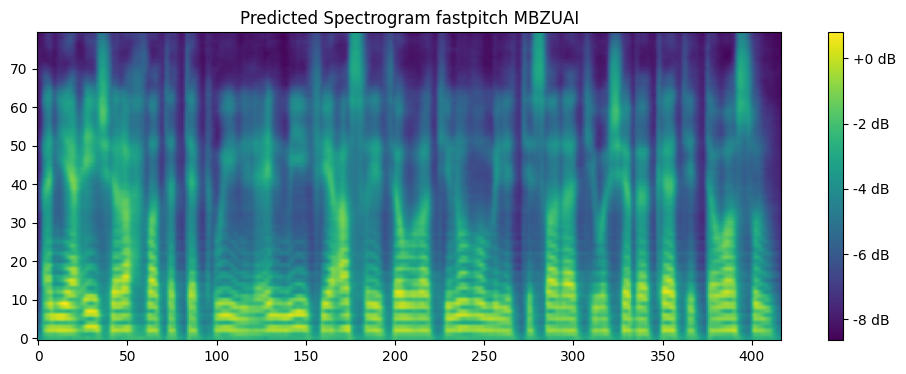

Predicted audio:


Noise Profile Reduction - Noise Removed:


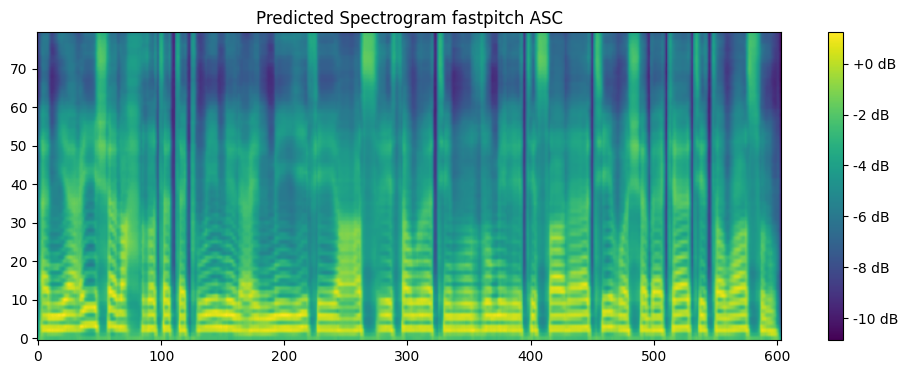

Predicted audio:


Noise Profile Reduction - Noise Removed:


In [35]:
import librosa
import librosa.display
import numpy as np
import torch
import matplotlib.pyplot as plt
import IPython.display as ipd
import noisereduce as nr
from sklearn.metrics import mean_squared_error
import re
import sys
sys.path.append('/kaggle/working')  # Append the directory, not the file
import arabic_phoneme_tokenizer
sys.path.append('tts-arabic-pytorch')
import text as txt
%matplotlib inline
import random

# text= 'S A b aa H u0 l x A y r i0 y aa S A d II0 q ii0'
# text = "b i0 s m i0 ll a h i0 rr a H m a n i0 rr a H ii0 m i0 l H a m d u0 l i0 ll a h i0 r a bb i0 l E a l a m ii0 n a rr a H m a n i0 rr a H ii0 m i0 m a l i0 k i0 y a uu0 m i0 dd ii0 n i0 < ii0 y aa k a n a E b u0 d u0 w a < ii0 y aa k a n a s t a E ii0 n u0 h d i0 n aa SS I0 r a T A l m u0 s t A q II0 m a S I0 r a T A ll a * ii0 n a < a n E a m t a E a l a ii0 h i0 m g A ii0 r i0 l m a g D UU0 b i0 E a l a ii0 h i0 m w a l aa DD AA ll ii0 n a"

text = "b i0 s m i0 ll a h i0 rr a H m a n i0 rr a H ii0 m i0"
text = "w a ss a l aa m u0 E a l aa < a $ r a f i0 l < a n b i0 y aa < i0 w a l m u0 r s a l ii0 n a n a b ii0 y i0 n aa m u0 H a mm a d i1 n"
text = "m a $ r uu0 E u1 n l i0 t a H w ii0 l i0 nn A SS I0 l E a r a b ii0 y i0 l aa k a l aa m i0"
text ="l H a m d u0 l i0 ll a h i0 r a bb i0 l E a l a m ii0 n a"
text = "h aa * i0 h i0 l A q T A t I1 n m u0 k a ^^ a f a t i1 n w a H a z ii0 n a t i1 n m U0 q A t TT A E a t a n m i0 n $ a r II0 T I0 T AA l i0 b i1 n E l m i1 n"
text = "< a n y a E ii0 $ a l a H Z A t A tt a k w ii0 n i0 l E i0 l m ii0 y i0 f ii0 E A S r i0 ^ a w r a t i0 n U0 Z U0 m i0 l i0 tt I0 S AA l aa t i0 w a $ a b a k aa t i0 tt a w AA S U0 l u0"

# # Function to compute mel spectrogram
def compute_mel_spectrogram(audio, sr=22050):
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1024, hop_length=256, n_mels=80)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram

# # # Load original audio and compute spectrogram
# original_audio, sr = librosa.load(audio_filepath, sr=22050)
# original_spectrogram = compute_mel_spectrogram(original_audio, sr)

seed = 20
# Predict audio and spectrogram
audio_mbz, pred_spec_mbz = evaluate_spec_fastpitch_ckpt(fastpitch_mbzuai_model, vocoder_fp_mbzuai, text)
audio_asc, pred_spec_asc = evaluate_spec_fastpitch_ckpt(fastpitch_asc_model, vocoder_gt_asc, text)


# # Plot original spectrogram
# plt.figure(figsize=(12, 4))
# plt.imshow(original_spectrogram, aspect="auto", origin="lower", cmap="magma")
# plt.title("Original Spectrogram")
# plt.colorbar(format="%+2.0f dB")
# plt.show()

# Plot predicted spectrogram FastPitch
plt.figure(figsize=(12, 4))
plt.imshow(pred_spec_mbz, origin="lower", aspect="auto", cmap="viridis")
plt.title("Predicted Spectrogram fastpitch MBZUAI")
plt.colorbar(format="%+2.0f dB")
plt.show()

print("Predicted audio:")
ipd.display(ipd.Audio(audio_mbz, rate=22050))

y = audio_mbz
y_denoised = nr.reduce_noise(y=y, sr=22050, y_noise=y)
print("Noise Profile Reduction - Noise Removed:")
ipd.display(ipd.Audio(1 * y_denoised, rate=22050))


#################################################################
# Plot predicted spectrogram FastPitch
plt.figure(figsize=(12, 4))
plt.imshow(pred_spec_asc, origin="lower", aspect="auto", cmap="viridis")
plt.title("Predicted Spectrogram fastpitch ASC")
plt.colorbar(format="%+2.0f dB")
plt.show()

print("Predicted audio:")
ipd.display(ipd.Audio(audio_asc, rate=22050))

y = audio_asc
y_denoised = nr.reduce_noise(y=y, sr=22050, y_noise=y)
print("Noise Profile Reduction - Noise Removed:")
ipd.display(ipd.Audio(1 * y_denoised, rate=22050))
